In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

from math import ceil
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile as SP
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


1. **X, y Dataframes Creation, train test Dataframes Creation**
    * Import the Data
2. **X,y Summary**
    * X Summary Stats
        * Null Values
        * Correlation Matrix
        * Removing data based on correlation between them
    * Y Summary Stats
        * Normalizing Response Variable
3. **Data Exploration**
    * Removing Columns with >50% Null Data
    * Data Visualisation for Categorical Variables
        * Removing Columns with most rows having only one category
        * Removing rows which have features not present in test data
4. **Feature Engineering**
    * Numerical Feature Creation
    * Ordered Categorical Columns
    * Filling Features and creating further mathematical transformations
    * Creating Features using Count
    * Creating new Boolean Features
    * Converting Categorical Features
    * Concatenating Original Features with the new Created Features
5. **Feature Selection**
    * Using MI Score
    * Take all features with MI score > 0
6. **Model Building**
    * Use 4 different models
    * CV to find out our best model
    * GridSearchCV to fine-tune our best model
7. **Avoid Overfitting**
    * Analysis of residuals to remove outliers
    

# 1) X, y Dataframes Creation, train test Dataframes Creation

In [109]:
# All inputs
df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
X_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

# Removing rows with missing target
df = df.dropna(axis=0, subset=['SalePrice'])

# Seperating target and Predictors
X_train = df.drop(['SalePrice'], axis = 1)
y_train = df.SalePrice

In [110]:
print(X_train.shape)
print(X_test.shape)

(1460, 79)
(1459, 79)


# 2) X,y Summary

## X Summary Stats

In [111]:
# To be able to view all rows
pd.set_option('display.max_rows', 100)

In [112]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [113]:
info = pd.DataFrame(X_train.dtypes, columns=['Dtypes'])
info['Unique'] = X_train.nunique().values
info['Null'] = X_train.isnull().sum().values
info

,Dtypes,Unique,Null
MSSubClass,int64,15,0
MSZoning,object,5,0
LotFrontage,float64,110,259
LotArea,int64,1073,0
Street,object,2,0
Alley,object,2,1369
LotShape,object,4,0
LandContour,object,4,0
Utilities,object,2,0
LotConfig,object,5,0


In [114]:
X_train.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

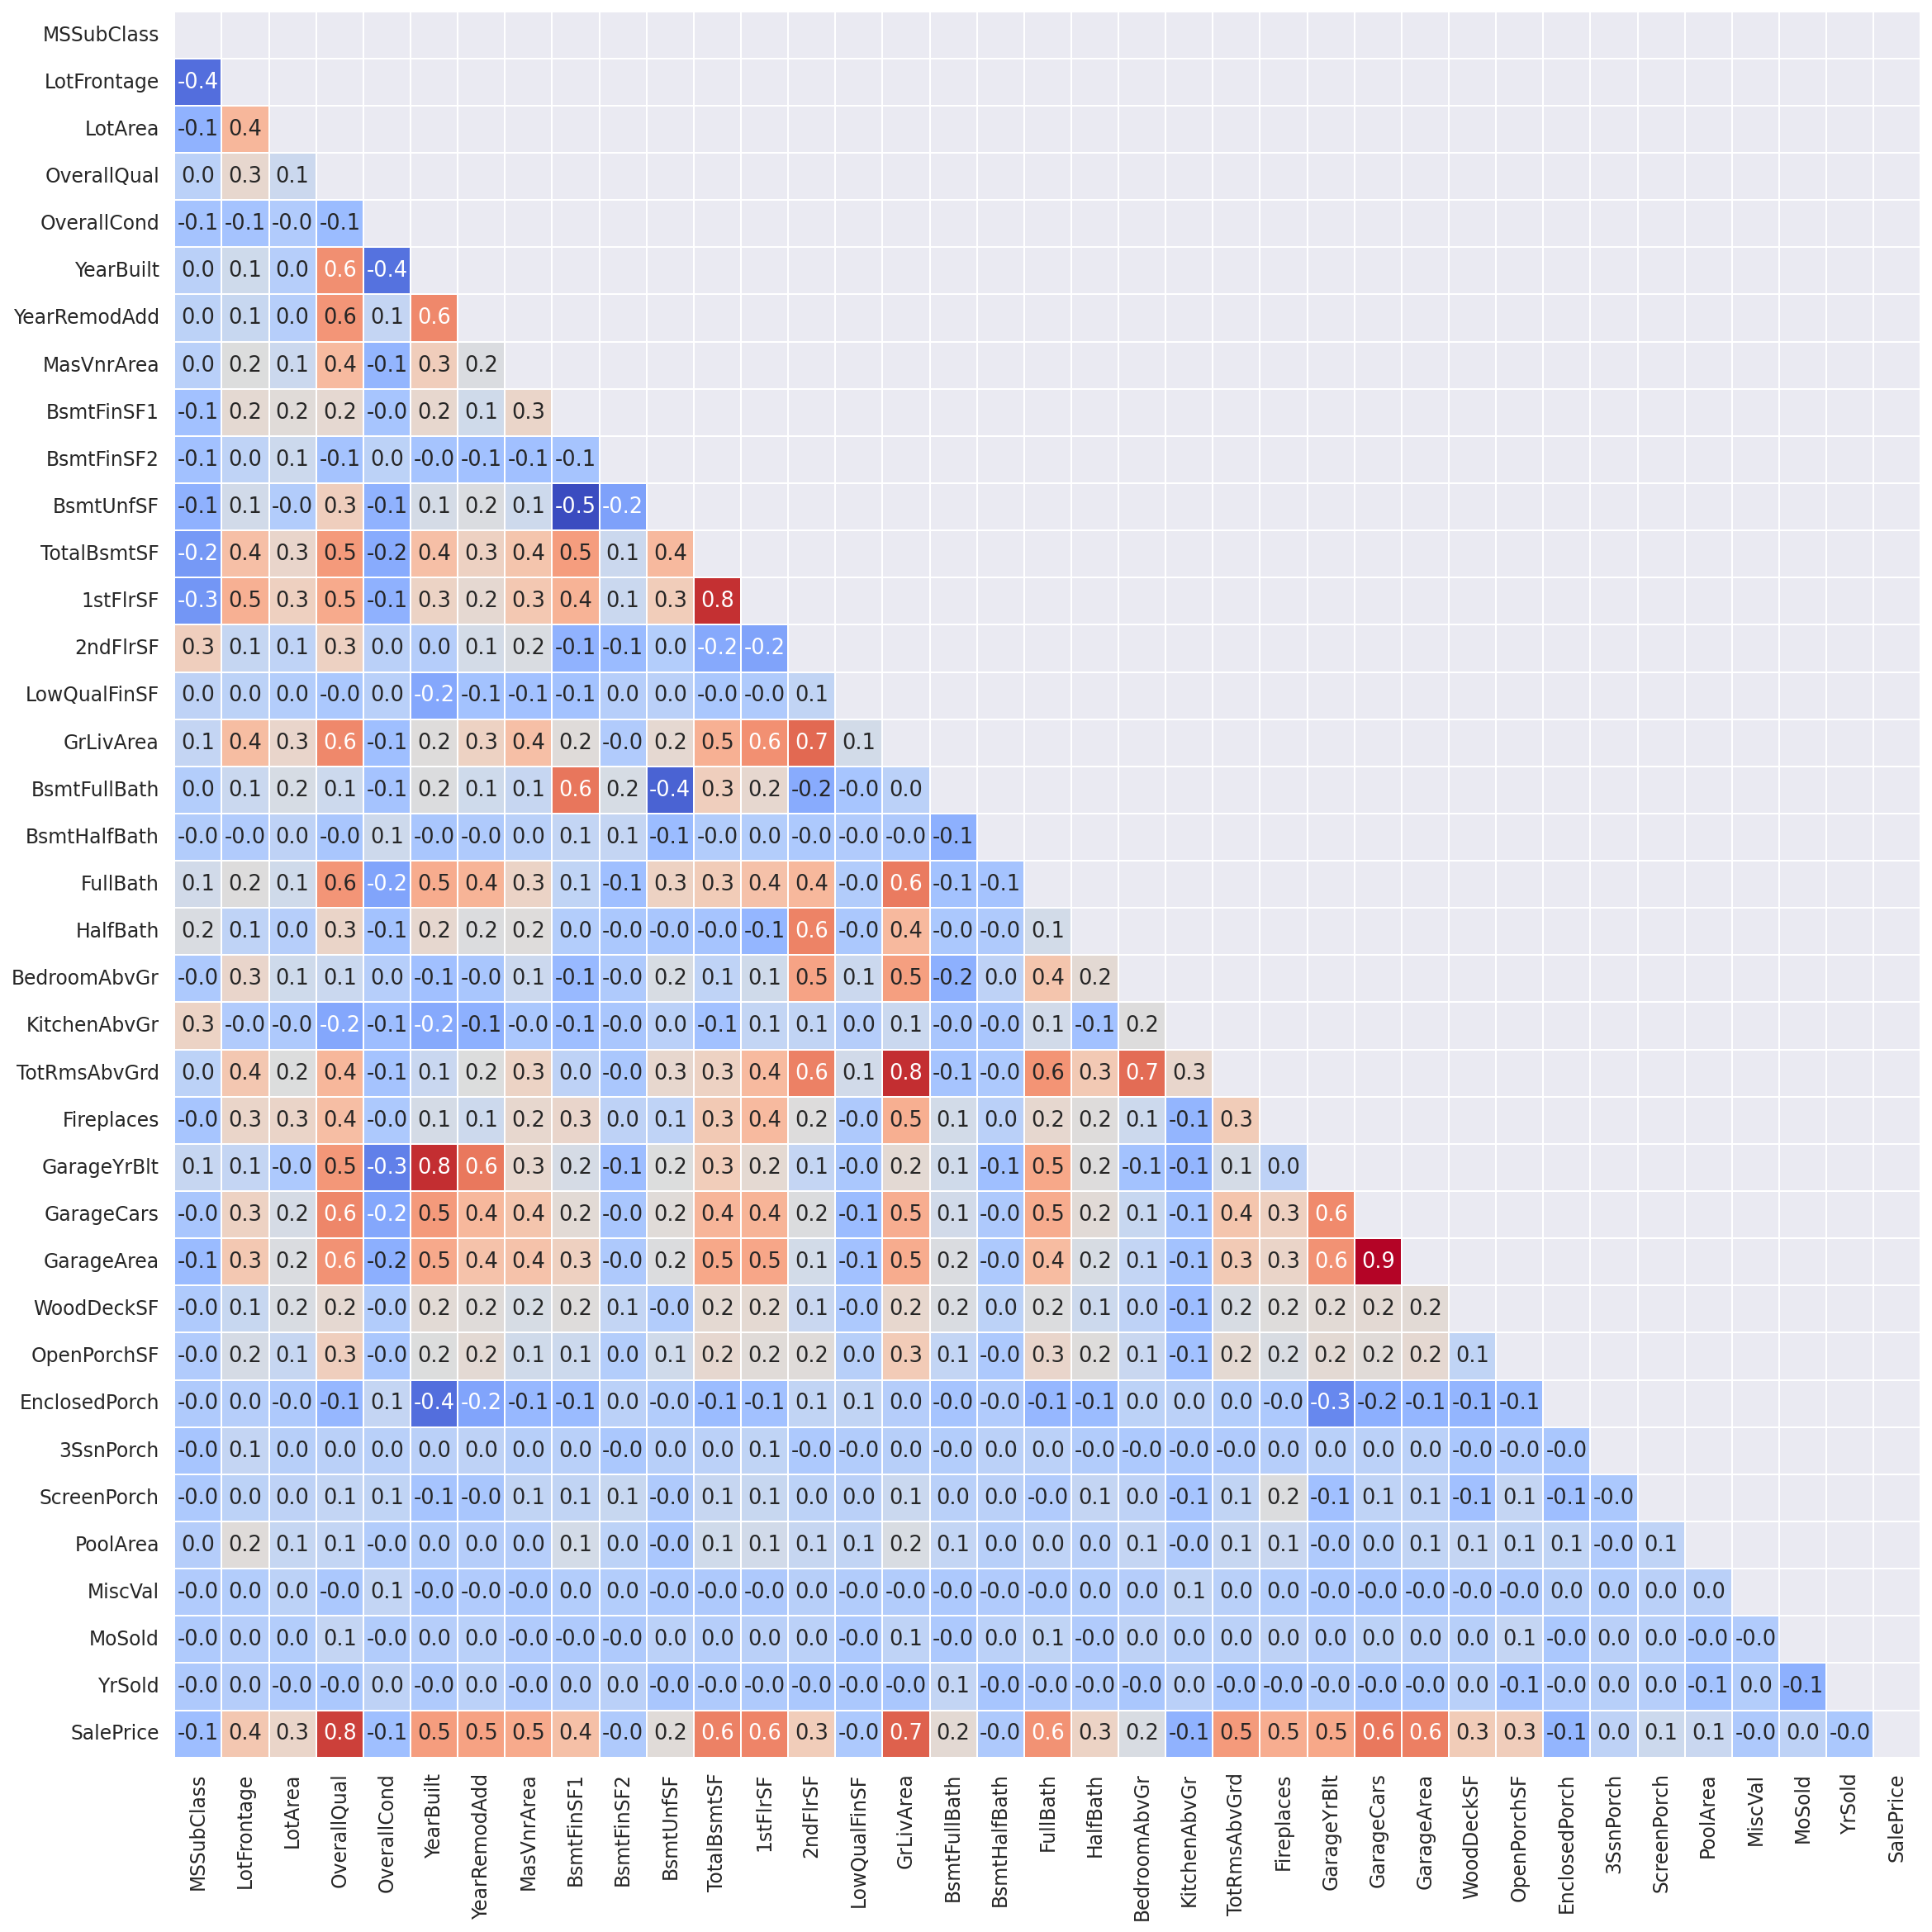

In [115]:
correlation_matrix = df.corr()

# Returns copy of array with upper part of the triangle (which will be masked/hidden)
mask = np.triu(correlation_matrix.corr())

sns.set(font_scale=1.1)
plt.figure(figsize=(20, 20), dpi=140)
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', 
            square=True, mask=mask, linewidths=1, cbar=False)
plt.show()

In [116]:
print(df[['GarageArea', 'GarageCars']].corr().values[0][1])
print(df[['1stFlrSF', 'TotalBsmtSF']].corr().values[0][1])
print(df[['GarageYrBlt', 'YearBuilt']].corr().values[0][1])
print(df[['TotRmsAbvGrd', 'GrLivArea']].corr().values[0][1])

0.882475414281462
0.8195299750050338
0.8256674841743407
0.8254893743088426


Since these 4 pairs have high correlation and logically they are related to each other we could choose to drop one of the two from each pair to reduce the number of predictors

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='GarageCars', ylabel='GarageArea'>

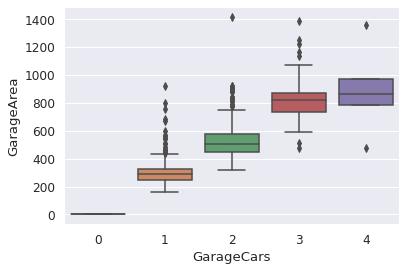

In [117]:
sns.boxplot(df.GarageCars, df.GarageArea)

In [118]:
sum(df.GarageCars==4)

5

We choose to drop GarageCars since similar data is already being considered in the form of GarageArea. We can see there is a clear distinction in the classes based on GarageArea from the above boxplot and with numberofcars==4 being an outlier.

We are dropping the simpler of the two as it might be too general the numerical column GarageArea would give more information.

In [119]:
X_train.drop(['GarageCars'], axis=1, inplace = True)
X_test.drop(['GarageCars'], axis=1, inplace = True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='1stFlrSF', ylabel='TotalBsmtSF'>

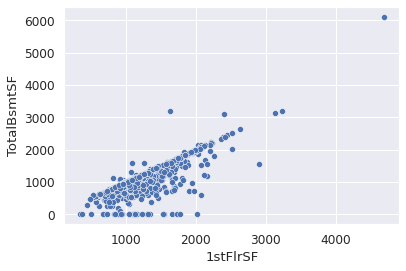

In [120]:
sns.scatterplot(df['1stFlrSF'], df.TotalBsmtSF)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='GrLivArea'>

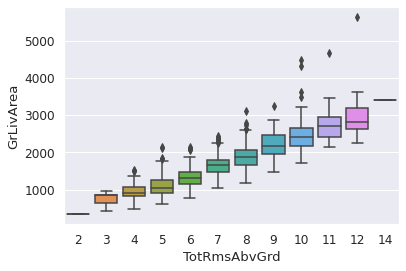

In [121]:
sns.boxplot(df.TotRmsAbvGrd, df.GrLivArea)

We choose to drop TotRmsAbvGrd since similar data is already being considered in the form of GrLivArea. We can see there is a clear distinction in the classes based on the GrLivArea from the above boxplot.

We are dropping the simpler of the two as it might be too general the numerical column GrLivArea would give more information.

In [122]:
X_train.drop(['TotRmsAbvGrd'], axis=1, inplace = True)
X_test.drop(['TotRmsAbvGrd'], axis=1, inplace = True)

## Y Summary Stats

In [123]:
y_train.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


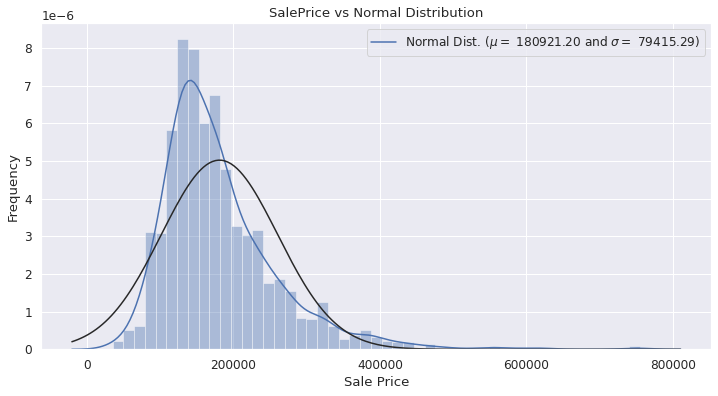

In [124]:
(mu, sigma) = stats.norm.fit(y_train)
plt.figure(figsize = (12,6))
sns.distplot(y_train, kde=True, hist=True, fit=stats.norm)
plt.title("SalePrice vs Normal Distribution")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.show()

Since the response variable SalePrice is not normal we will apply a log transform to make it normal

The final evaluation metric for the kaggle competition is also based on the RMSE between log predicted and actual values to give equal weighting to both ttthe large and small SalePrice values

mu = 12.02 and sigma = 0.40



/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


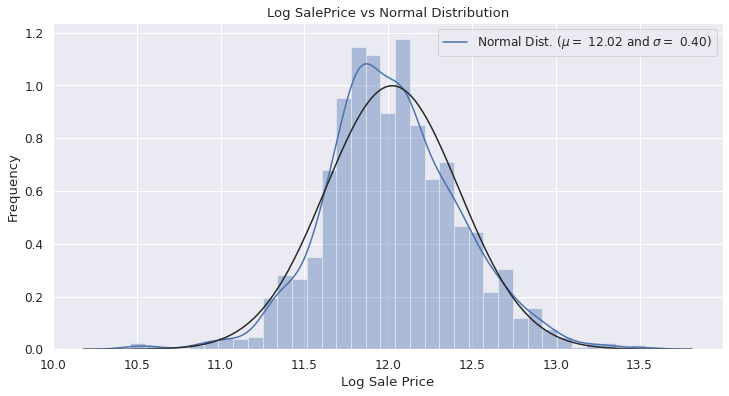

In [125]:
(mu, sigma) = stats.norm.fit(np.log(y_train))
print('mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.figure(figsize = (12,6))
sns.distplot(np.log(y_train), kde=True, hist=True, fit=stats.norm)
plt.title("Log SalePrice vs Normal Distribution")
plt.xlabel("Log Sale Price")
plt.ylabel("Frequency")
plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.show()

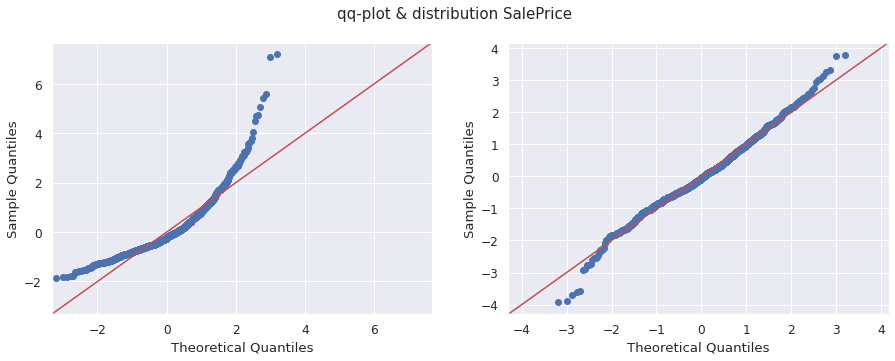

In [126]:
# SalePrice before and after transformation
fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)
sm.qqplot(y_train, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sm.qqplot(np.log(y_train), fit=True, line = "45", ax=ax[1])
plt.show()

In [127]:
# Therefore for model prediction we take log Sale Price
#y_train = np.log(y_train)

# 3) Data Exploration

In [128]:
print("Total Missing Values")
print("Training data\t",X_train.isnull().sum().sum())
print("Testing data\t",X_test.isnull().sum().sum())

Total Missing Values
Training data	 6965
Testing data	 6999


## Removing columns with more than half missing values 

In [129]:
def null_values(X_train, X_test):
    null_train = X_train.isnull().sum()
    null_test = X_test.isnull().sum()
    
    df_dict = {'Train Data': null_train,
                'Test Data': null_test}
    null_df = pd.DataFrame(df_dict)
    
    null_df = null_df.loc[(null_df['Train Data']!=0) | (null_df['Test Data']!=0)]
    null_df = null_df.sort_values(by=['Train Data','Test Data'],ascending=False)
    
    return null_df

In [130]:
null_vals = null_values(X_train, X_test)
null_vals

,Train Data,Test Data
PoolQC,1453,1456
MiscFeature,1406,1408
Alley,1369,1352
Fence,1179,1169
FireplaceQu,690,730
LotFrontage,259,227
GarageYrBlt,81,78
GarageFinish,81,78
GarageQual,81,78
GarageCond,81,78


In [131]:
null_cols = [col for col in X_train.columns if X_train[col].isnull().sum()>len(X_train)/2]
null_cols

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

Since these are all categorical features and NA values respresent that the feature does not exist in the house we drop the columns since more than half the houses do not have these features and they would be highly imbalanced if more than 50% of the houses do not have these features

In [132]:
X_train.drop(null_cols, axis=1, inplace=True)
X_test.drop(null_cols, axis=1, inplace=True)

In [133]:
print("Remaining Missing Values")
print("Training data\t",X_train.isnull().sum().sum())
print("Testing data\t",X_test.isnull().sum().sum())

Remaining Missing Values
Training data	 1558
Testing data	 1614


## Data Visualisation for Categorical Data

In [134]:
cat_cols = X_train.select_dtypes('object').columns

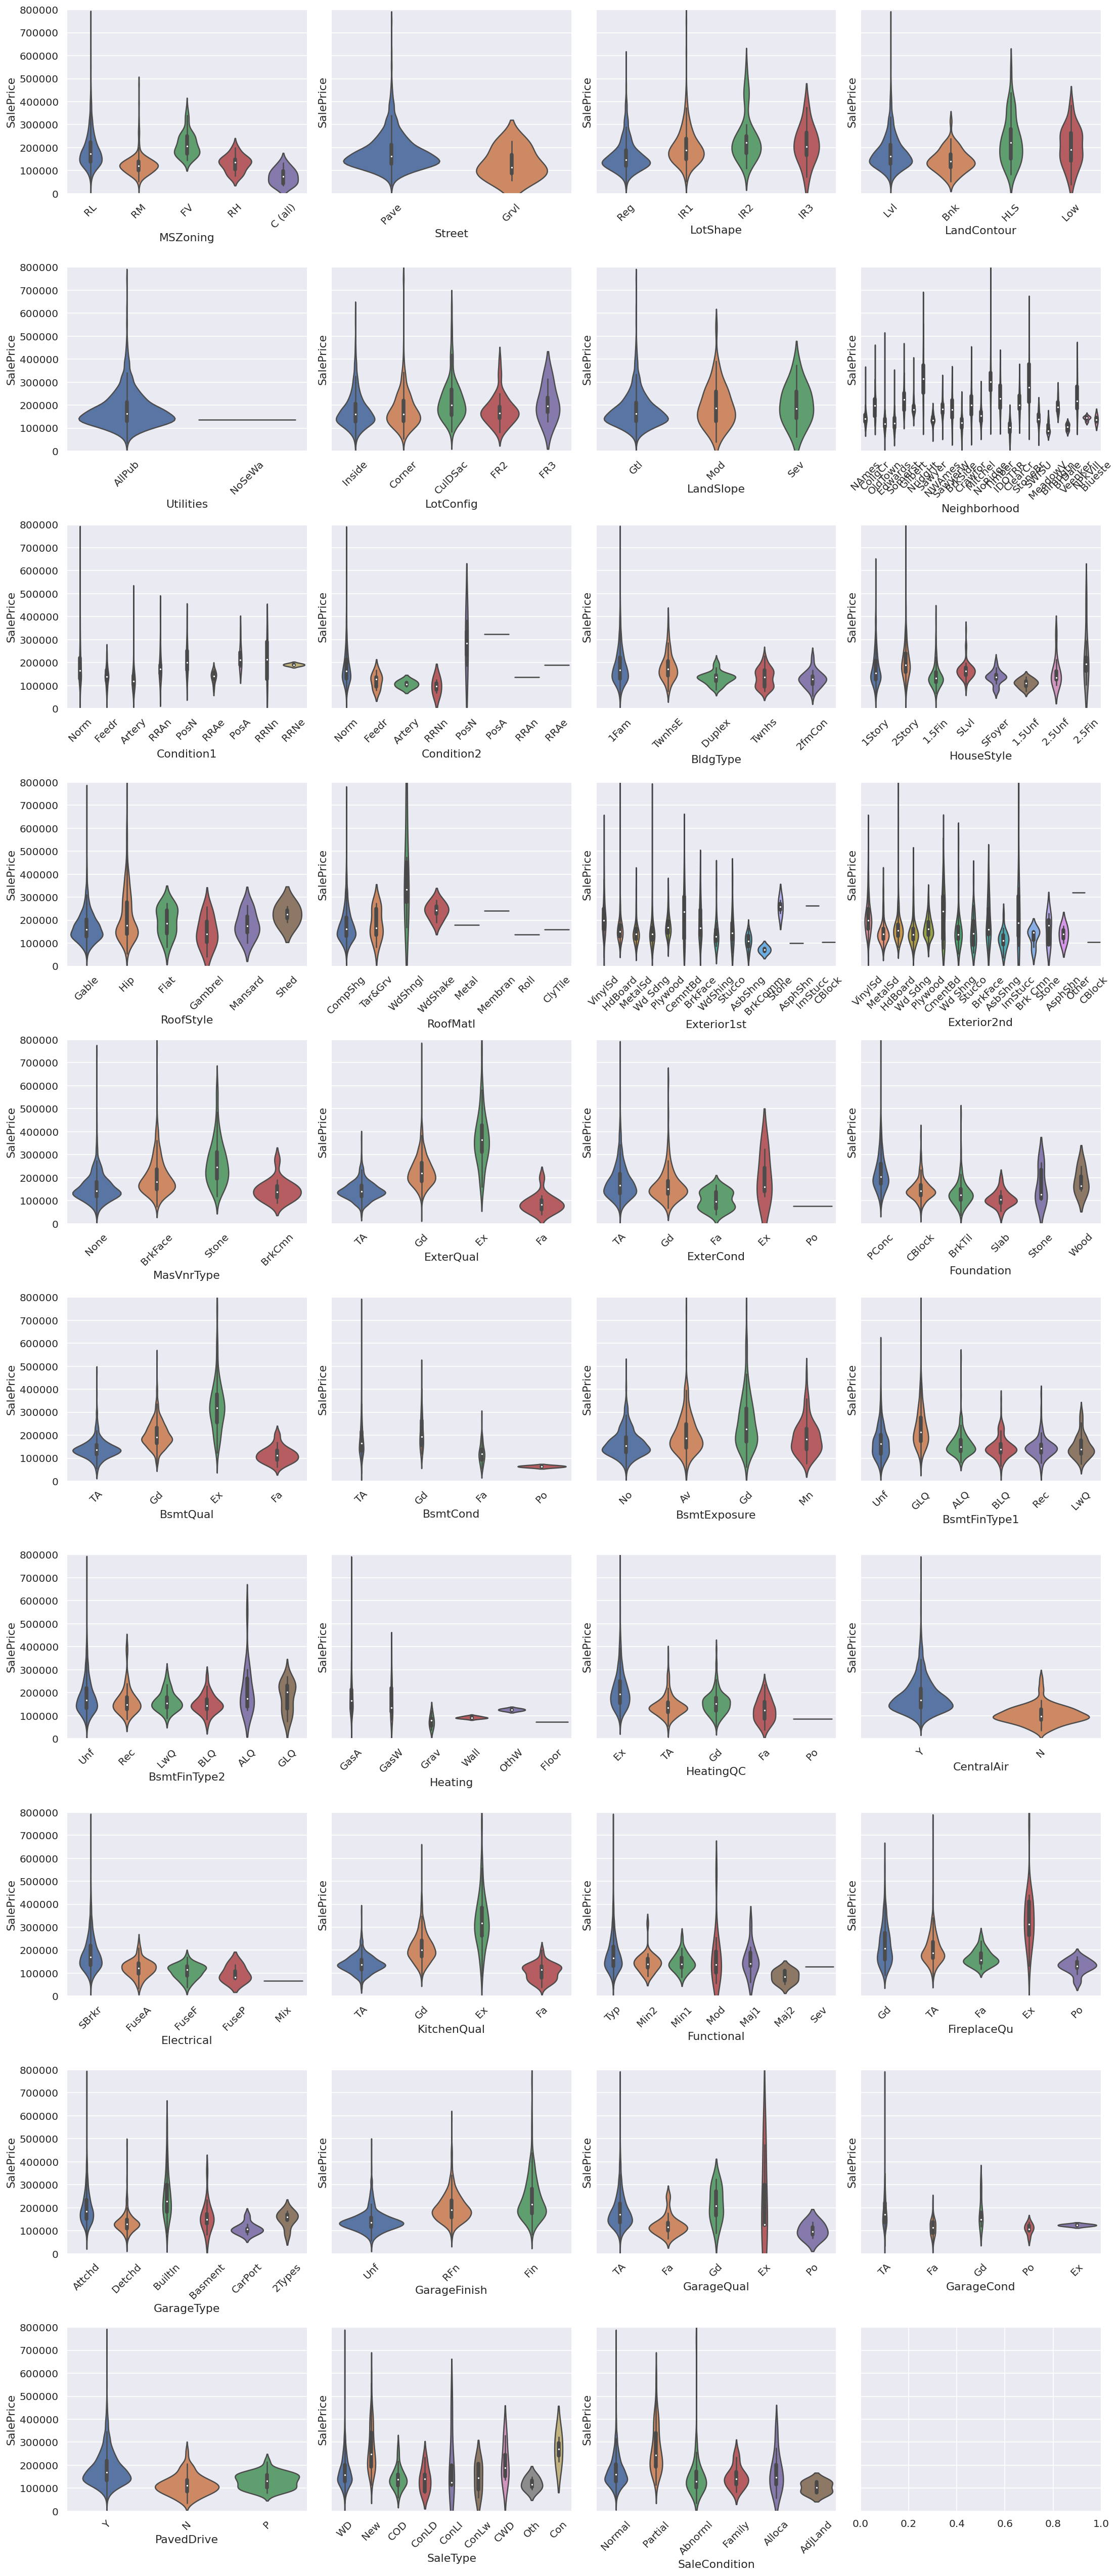

In [135]:
fig, ax = plt.subplots(nrows=ceil(len(cat_cols) / 4), ncols=4, figsize=(22, 1.4*len(cat_cols)), sharey=True, dpi=120)

for col, subplot in zip(cat_cols, ax.flatten()):
    freq = X_train[col].value_counts()
    subplot.ticklabel_format(style='plain')
    plt.ylim([0, 800000])
    plt.subplots_adjust(wspace=.1,hspace=.4)
    for tick in subplot.get_xticklabels():
        tick.set_rotation(45)
    sns.violinplot(data=X_train, x=col, y=df.SalePrice, order=freq.index, ax=subplot)

### From the above violin plots checking those categorical features that have highly under represented data 

Not including those which have been tested but have no difference

In [136]:
print(X_train.Utilities.value_counts())
print(X_test.Utilities.value_counts())

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
AllPub    1457
Name: Utilities, dtype: int64


In [137]:
X_train.drop('Utilities',axis=1,inplace=True)
X_test.drop('Utilities',axis=1,inplace=True)

In [138]:
print(X_train.Condition2.value_counts())
print(X_test.Condition2.value_counts())

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
Norm      1444
Feedr        7
PosA         3
Artery       3
PosN         2
Name: Condition2, dtype: int64


In [139]:
# Dropping those categories which are under represented and not in X_test
y_train.drop(X_train.index[X_train['Condition2'] == 'RRAe'], inplace=True)
X_train.drop(X_train.index[X_train['Condition2'] == 'RRAe'], inplace=True)
y_train.drop(X_train.index[X_train['Condition2'] == 'RRAn'], inplace=True)
X_train.drop(X_train.index[X_train['Condition2'] == 'RRAn'], inplace=True)
y_train.drop(X_train.index[X_train['Condition2'] == 'PosA'], inplace=True)
X_train.drop(X_train.index[X_train['Condition2'] == 'PosA'], inplace=True)

In [140]:
print(X_train.Electrical.value_counts())
print(X_test.Electrical.value_counts())

SBrkr    1331
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


In [141]:
y_train.drop(X_train.index[X_train['Electrical'] == 'Mix'], inplace=True)
X_train.drop(X_train.index[X_train['Electrical'] == 'Mix'], inplace=True)

In [142]:
print(X_train.Heating.value_counts())
print(X_test.Heating.value_counts())

GasA     1424
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64
GasA    1446
GasW       9
Grav       2
Wall       2
Name: Heating, dtype: int64


In [143]:
y_train.drop(X_train.index[X_train['Heating'] == 'Floor'], inplace=True)
X_train.drop(X_train.index[X_train['Heating'] == 'Floor'], inplace=True)

In [144]:
print(X_train.RoofMatl.value_counts())
print(X_test.RoofMatl.value_counts())

CompShg    1429
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64
CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64


In [145]:
y_train.drop(X_train.index[X_train['RoofMatl'] == 'Metal'], inplace=True)
X_train.drop(X_train.index[X_train['RoofMatl'] == 'Metal'], inplace=True)
y_train.drop(X_train.index[X_train['RoofMatl'] == 'Membran'], inplace=True)
X_train.drop(X_train.index[X_train['RoofMatl'] == 'Membran'], inplace=True)
y_train.drop(X_train.index[X_train['RoofMatl'] == 'Roll'], inplace=True)
X_train.drop(X_train.index[X_train['RoofMatl'] == 'Roll'], inplace=True)
y_train.drop(X_train.index[X_train['RoofMatl'] == 'Clytile'], inplace=True)
X_train.drop(X_train.index[X_train['RoofMatl'] == 'Clytile'], inplace=True)

In [146]:
print("Remaining Missing Values")
print("Training data\t",X_train.isnull().sum().sum())
print("Testing data\t",X_test.isnull().sum().sum())

Remaining Missing Values
Training data	 1545
Testing data	 1612


# 4) Feature Engineering

In [147]:
X_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object
CentralAir        object
Electrical        object


In [148]:
df = pd.concat([X_train, X_test])

## 4.1) Numerical Feature Creation

In [149]:
df1 = pd.DataFrame()  # dataframe to hold new features

# Age of House when sold
df1['Age'] = df['YrSold']-df['YearBuilt']

# Years between Remodeling and sales
df1['AgeRemodel'] = df['YrSold']-df['YearRemodAdd']

year_cols = ['YrSold','YearBuilt','AgeRemodel', 'Age', 'YearRemodAdd']
df_1 = pd.concat([df, df1], axis=1).loc[:,year_cols]
X_1 = df_1.loc[X_train.index, :]
X_1.sample()

,YrSold,YearBuilt,AgeRemodel,Age,YearRemodAdd
Id,,,,,
1228,2008,1965,0,43,2008


In [150]:
X_1.corrwith(y_train)

YrSold         -0.030195
YearBuilt       0.527345
AgeRemodel     -0.507001
Age            -0.527831
YearRemodAdd    0.505016
dtype: float64

Dropping YrSold due to very poor correlation with SalePrice

In [151]:
df.drop(['YrSold'], inplace=True, axis=1)

In [152]:
df1['TotalBathrooms'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
df1['Bathrooms'] = df['FullBath'] + 0.5*df['HalfBath']
df1['BasementBathrooms'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
df1['HomeQuality'] = df['OverallQual']+df['OverallCond']

cols = ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OverallQual','OverallCond','TotalBathrooms','Bathrooms','BasementBathrooms', 'HomeQuality']
df_1 = pd.concat([df, df1], axis=1).loc[:,cols]
X_1 = df_1.loc[X_train.index, :]
X_1.sample()

,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath,OverallQual,OverallCond,TotalBathrooms,Bathrooms,BasementBathrooms,HomeQuality
Id,,,,,,,,,,
1141,1,0,1.0,0.0,5,7,2.0,1.0,1.0,12


In [153]:
X_1.corrwith(y_train)

FullBath             0.560613
HalfBath             0.282987
BsmtFullBath         0.226597
BsmtHalfBath        -0.017100
OverallQual          0.790314
OverallCond         -0.086080
TotalBathrooms       0.630296
Bathrooms            0.598300
BasementBathrooms    0.224390
HomeQuality          0.592476
dtype: float64

In [154]:
# Dropping since newly created column TotalBathrooms has better correlation
df.drop(['FullBath'], inplace=True, axis=1)
df.drop(['HalfBath'], inplace=True, axis=1)
df.drop(['BsmtHalfBath'], inplace=True, axis=1)
df.drop(['BsmtFullBath'], inplace=True, axis=1)

# Dropping OverallCond since individual OverallCond is bad and information is captured in new HomeQuality
cols_to_drop = ['OverallCond']

# Dropping BasementBathrooms since correlation is bad and information is captured between TotalBathrooms and Bathrooms
cols_to_drop.append('BasementBathrooms')


In [155]:
df1['OpenArea'] = df['LotArea'] - df['1stFlrSF']

cols = ['OpenArea']
df_1 = pd.concat([df, df1], axis=1).loc[:,cols]
X_1 = df_1.loc[X_train.index, :]
X_1.sample()

,OpenArea
Id,
498,7987


## 4.2) Ordered Categorical Columns

In [156]:
object_cols = df.select_dtypes(include=['object']).columns
# Categorical Columns with number of unuque categoies in them 
df[object_cols].nunique().sort_values()

Street            2
CentralAir        2
LandSlope         3
PavedDrive        3
GarageFinish      3
LotShape          4
LandContour       4
BsmtExposure      4
BsmtCond          4
BsmtQual          4
Electrical        4
ExterQual         4
KitchenQual       4
MasVnrType        4
MSZoning          5
ExterCond         5
RoofMatl          5
HeatingQC         5
BldgType          5
GarageQual        5
GarageCond        5
LotConfig         5
FireplaceQu       5
Heating           5
GarageType        6
Foundation        6
BsmtFinType1      6
RoofStyle         6
Condition2        6
BsmtFinType2      6
SaleCondition     6
Functional        7
HouseStyle        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

From the data description we know that some of these columns have levels of quality, condition or finish. These columns can be used as ordinal colums (Ordered Categorical Columns)

In [157]:
ordinal_cols = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Fin' in i) or ('Cond' in i) and ('Condition' not in i)]
df.loc[:,ordinal_cols] = df.loc[:,ordinal_cols].fillna('NA')
print("Column Names: [Unique Categories in each column]")
{col:[*df[col].unique()] for col in ordinal_cols}

Column Names: [Unique Categories in each column]


{'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'BsmtQual': ['Gd', 'TA', 'Ex', 'NA', 'Fa'],
 'BsmtCond': ['TA', 'Gd', 'NA', 'Fa', 'Po'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'NA', 'LwQ'],
 'BsmtFinType2': ['Unf', 'BLQ', 'NA', 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'KitchenQual': ['Gd', 'TA', 'Ex', 'Fa', 'NA'],
 'FireplaceQu': ['NA', 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'GarageFinish': ['RFn', 'Unf', 'Fin', 'NA'],
 'GarageQual': ['TA', 'Fa', 'Gd', 'NA', 'Ex', 'Po'],
 'GarageCond': ['TA', 'Fa', 'NA', 'Gd', 'Po', 'Ex']}

In [158]:
# 1] Columns with similar ordered categories [Poor<Fair<Typical/Average<Good<Excellent]
ordinal_cols1 = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Cond' in i) and ('Condition' not in i)]
df.loc[:,ordinal_cols1] = df.loc[:,ordinal_cols1].replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])

# 2] Columns with similar ordered categories [No Garage/Basement<Unfinished<Rough Finished<Finished,etc]
ordinal_cols2 = ['BsmtFinType1', 'BsmtFinType2']
df.loc[:,ordinal_cols2] = df.loc[:,ordinal_cols2].replace(['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [0,1,2,3,4,5,6])

# 3] Column with ordered categories [No Basement<No Exposure<Mimimum Exposure<Average Exposure<Good Exposure]
ordinal_cols3 = ['BsmtExposure']
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].fillna('NA')
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].replace(['NA', 'No', 'Mn', 'Av', 'Gd'], [0,1,2,3,4])

# 4] Column with ordered categories [Regular<Slightly irregular<Moderately Irregular<Irregular]
ordinal_cols4 = ['LotShape']
df.loc[:,ordinal_cols4] = df.loc[:,ordinal_cols4].replace(['Reg', 'IR1', 'IR2', 'IR3'], [0,1,2,3])

# 5] Column with ordered categories [No Garage<Unfinished<Rough Finished<Finished]
ordinal_cols5 = ['GarageFinish']
df.loc[:,ordinal_cols5] = df.loc[:,ordinal_cols5].replace(['NA', 'Unf', 'RFn', 'Fin'], [0,1,2,3])

# 6] Home functionality Column
ordinal_cols6 = ['Functional']
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].fillna('Mod')
df.loc[:,ordinal_cols6] = df.loc[:,ordinal_cols6].replace(["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"], list(range(8)))

In [159]:
o_columns = ordinal_cols1+ordinal_cols2+ordinal_cols3+ordinal_cols4+ordinal_cols5+ordinal_cols6
df.loc[:,o_columns].dtypes.value_counts()

int64      14
float64     1
dtype: int64

## 4.3) Filling features and creating further mathematical transformations

In [160]:
# Filling with 0 since if a basement or 1st or 2nd floor not present then total SF should be 0
SF_cols = ['TotalBsmtSF','1stFlrSF','2ndFlrSF',"WoodDeckSF","OpenPorchSF"]
df[SF_cols] = df[SF_cols].fillna(0)

# If NA then the Garage was built at the same time as the house
df['GarageYrBlt'].fillna(df['YearBuilt'], inplace=True)

# If lot frontage not there make best estimate by taking average from the neighborhood
df['LotFrontage'] = df.groupby(['Neighborhood'], sort=False)['LotFrontage'].apply(lambda x: x.fillna(x.mean()))

df['MasVnrArea'].fillna(0, inplace=True)

In [161]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'Sal

In [162]:
df3 = pd.DataFrame()

df3["LivingQuality"] = (df.OverallQual + df.OverallCond/3) * df.GrLivArea
df3["LivLotRatio"] = df.GrLivArea / df.LotArea
df3['TotalSF'] = df[SF_cols].sum(axis = 1)

new_cols = ['LivingQuality','LivLotRatio','TotalSF']
df_3 = pd.concat([df, df3], axis=1).loc[:,new_cols]
X_3 = df_3.loc[X_train.index, :]
X_3.sample()

,LivingQuality,LivLotRatio,TotalSF
Id,,,
389,12818.0,0.157642,3092.0


In [163]:
X_3.corrwith(y_train)

LivingQuality    0.815538
LivLotRatio     -0.003298
TotalSF          0.792221
dtype: float64

In [164]:
cols_to_drop.append('LivLotRatio')

## 4.4) Creating Features using Count

In [165]:
df4 = pd.DataFrame()

Porches = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]
df4["PorchTypes"] = df[Porches].gt(0.0).sum(axis=1)

new_cols = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch", 'PorchTypes']
df_4 = pd.concat([df, df4], axis=1).loc[:,new_cols]
X_4 = df_4.loc[X_train.index, :]
X_4.sample()

,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PorchTypes
Id,,,,,,
126,53,0,0,0,0,1


In [166]:
X_4.corrwith(y_train)

WoodDeckSF       0.323580
OpenPorchSF      0.312274
EnclosedPorch   -0.129660
3SsnPorch        0.044942
ScreenPorch      0.111563
PorchTypes       0.407165
dtype: float64

In [167]:
cols_to_drop.append('3SsnPorch')
cols_to_drop.append('EnclosedPorch')
cols_to_drop.append('ScreenPorch')

## 4.5) Creating new Boolean Features

In [168]:
df5 = pd.DataFrame()

# Ignored due to bad correlation
df5['Remodel'] = df['YearRemodAdd']!=df['YearBuilt'] 
df5['Masonry'] = df['MasVnrType'].notnull()

df5 = df5.replace([False,True], [0,1])
df5.sample()

,Remodel,Masonry
Id,,
1206,1,1


In [169]:
df5.corrwith(y_train)

Remodel   -0.021794
Masonry   -0.052021
dtype: float64

## 4.6) Converting Categorical Features

We use Label Encoding since we have a lot of categorical variables in our data and Label Encoding can be used for tree based models.

In [170]:
# Since MSSubClass is actually categorical
categorical_features = ["MSSubClass"] + list(df.select_dtypes('object').columns)

# Casting to category datatype
for name in categorical_features:
    df[name] = df[name].astype("category")
    
    # Add a None category for missing values
    if "None" not in df[name].cat.categories:
        df[name] = df[name].cat.add_categories("None")

In [171]:
# Label encoding for categoricals
for colname in df.select_dtypes(["category"]):
    df[colname] = df[colname].cat.codes

In [172]:
df.dtypes.value_counts()

int64      34
int8       24
float64     9
dtype: int64

## Concatenating Original Features with all the new Created Features

In [173]:
df = pd.concat([df,df1,df3,df4], axis=1)
df.sample()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,AgeRemodel,TotalBathrooms,Bathrooms,BasementBathrooms,HomeQuality,OpenArea,LivingQuality,LivLotRatio,TotalSF,PorchTypes
Id,,,,,,,,,,,,,,,,,,,,,
504,0,3,100.0,15602,1,1,3,4,0,6,...,13,3.0,2.0,1.0,15,13801,17409.666667,0.115434,3356.0,2


In [174]:
df.shape

(2911, 78)

In [175]:
df.drop(columns=cols_to_drop, inplace=True)

In [176]:
# Reform splits
X_train = df.loc[X_train.index, :]
X_test = df.loc[X_test.index, :]

In [177]:
print(X_train.shape)
print(X_test.shape)

(1452, 72)
(1459, 72)


# 5) Feature Selection

In [178]:
X_train.isna().sum().sum()

0

In [179]:
y_train.isna().sum()

0

In [182]:
def make_mi_scores(X, y):
    X = X.copy()
    # All discrete features should now have integer dtypes
    # discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X.select_dtypes('number'), y, random_state=0)
    mi_scores = pd.DataFrame(mi_scores.round(2), columns=["MI_Scores"], index=X.select_dtypes('number').columns)
    return mi_scores

In [183]:
mi_scores = make_mi_scores(X_train, y_train)
linear_corr = pd.DataFrame(X_train.corrwith(y_train).round(2), columns=['Lin_Correlation'])

corr_with_price = pd.concat([mi_scores, linear_corr], axis=1)
corr_with_price = corr_with_price.sort_values('MI_Scores',ascending=False)

def feature_selector(i, data):

    selected_features = []

    for row in corr_with_price.head(i).index:
        selected_features.append(''+row)
    X_model = pd.DataFrame(data).loc[:,selected_features]
    
    return X_model

In [184]:
corr_with_price

,MI_Scores,Lin_Correlation
LivingQuality,0.73,0.82
TotalSF,0.69,0.79
OverallQual,0.55,0.79
Neighborhood,0.51,0.21
GrLivArea,0.49,0.71
TotalBsmtSF,0.37,0.61
YearBuilt,0.37,0.53
GarageArea,0.36,0.62
BsmtQual,0.35,0.59
KitchenQual,0.34,0.66


In [185]:
top = sum(corr_with_price.MI_Scores>0.1)

In [186]:
mean_score = []
top = []
for i in range(1,len(corr_with_price)):
    scores = []
    X_model = feature_selector(i, X_train)
    regressor = DecisionTreeRegressor(random_state=0)
    scores.append(cross_val_score(regressor, X_model, np.log(y_train)))# Using default 5 fold cv
    mean_score.append(np.mean(scores))
    top.append(i)    

In [187]:
top_scores = pd.DataFrame({'scores':mean_score,
                                 'top':top})
top = int(np.rint(np.mean(top_scores.sort_values(by='scores', ascending=False).head(10).top)))
top

40

We take the average score of the top 5 values

# 6) Model Building

In [188]:
X_model = feature_selector(top, X_train)

In [189]:
cv_scores, cv_sd = [], []

In [190]:
def rmse(model):
    return np.sqrt(-cross_val_score(model, X_model, np.log(y_train), scoring="neg_mean_squared_error"))

In [191]:
def learning_function(model):
    score = rmse(model)
    cv_scores.append(score.mean())
    cv_sd.append(score.std())

In [192]:
models = [
    DecisionTreeRegressor(),               # Decision Tree Regressor
    RandomForestRegressor(n_estimators=1000),               # Random Forest Regressor
    XGBRegressor(max_depth=3, learning_rate=0.1)
]

In [193]:
model_name = [
    'DecisionTreeRegressor',
    'RandomForestRegressor',
    'XGBRegressor'
]

In [194]:
for model in models:
    learning_function(model)

In [195]:
cv_scores

[0.19322173449348984, 0.13227781416640788, 0.1254972100864386]

In [196]:
cv_sd

[0.014642154029666255, 0.007140795218175019, 0.009019928985393815]

In [197]:
final_cv_score = pd.DataFrame(model_name, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_sd
final_cv_score

,Regressors,RMSE_mean,RMSE_std
0,DecisionTreeRegressor,0.193222,0.014642
1,RandomForestRegressor,0.132278,0.007141
2,XGBRegressor,0.125497,0.009020


In [198]:
best_regressor_name = final_cv_score.sort_values(by=['RMSE_mean']).head(1)['Regressors'].iloc[0]
best_regressor = models[model_name.index(best_regressor_name)]
best_regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)

In [199]:
param_grid = [
    {'n_estimators': [100, 150, 200, 500, 1000],
     'max_depth':range(3,7,2)}
]
grid_search = GridSearchCV(best_regressor, param_grid, cv=3, verbose=1, scoring='neg_root_mean_squared_error')

In [200]:
best_regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)

In [201]:
grid_search.fit(X_model, np.log(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max_cat_...elta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                      

In [202]:
grid_search.best_params_

{'max_depth': 3, 'n_estimators': 200}

In [203]:
print("RMSLE on training data:",round(-grid_search.score(X_model, np.log(y_train)),4))
print("RMSLE on validation data:",round(-grid_search.best_score_,4))

RMSLE on training data: 0.0711
RMSLE on validation data: 0.1265


# 7) Avoid Overfitting

#### Residual Analysis to see outliers

In [204]:
X_train_id = X_train.reset_index()

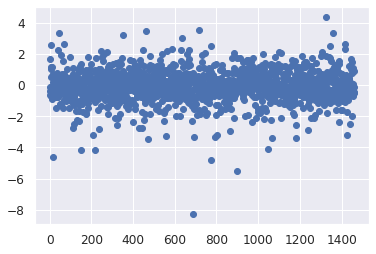

In [205]:
y_hat_pred = np.exp(grid_search.predict(X_model))
error = y_hat_pred-y_train
rmse = np.sqrt(sum((y_train-y_hat_pred)**2)/len(y_train))
ei = error/rmse
plt.scatter(X_train_id.Id, ei)

In [206]:
X_train['ei'] = ei
X_train['outlier'] = X_train['ei'].apply(lambda x : True if (x<-3 or x>3) else False)

In [207]:
y_train.drop(X_train.index[X_train['outlier'] == True], inplace=True)
X_train.drop(X_train.index[X_train['outlier'] == True], inplace=True)

In [208]:
X_train.drop(['outlier', 'ei'], axis=1, inplace=True)

In [209]:
X_model = feature_selector(top, X_train) 
#X_model.drop_duplicates(inplace=True)
X_model


,LivingQuality,TotalSF,OverallQual,Neighborhood,GrLivArea,TotalBsmtSF,YearBuilt,GarageArea,BsmtQual,KitchenQual,...,BsmtFinSF1,MSZoning,OpenPorchSF,BsmtFinType1,Exterior1st,BsmtUnfSF,PorchTypes,OpenArea,LotShape,WoodDeckSF
Id,,,,,,,,,,,,,,,,,,,,,
1,14820.000000,2627.0,7,5,1710,856.0,2003,548.0,4,4,...,706.0,3,61,6,12,150.0,1,7594,0,0
2,10937.333333,2822.0,6,24,1262,1262.0,1976,460.0,4,3,...,978.0,3,0,5,8,284.0,1,8338,0,298
3,15478.666667,2748.0,7,5,1786,920.0,2001,608.0,4,4,...,486.0,3,42,6,12,434.0,1,10330,1,0
4,14880.666667,2508.0,7,6,1717,756.0,1915,642.0,3,4,...,216.0,3,35,5,13,540.0,2,8589,1,0
5,21247.333333,3619.0,8,15,2198,1145.0,2000,836.0,4,4,...,655.0,3,84,6,12,490.0,2,13115,1,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,12627.000000,2640.0,6,8,1647,953.0,1999,460.0,4,3,...,0.0,3,40,1,12,953.0,1,6964,0,0
1457,16584.000000,3964.0,6,14,2073,1542.0,1978,500.0,4,3,...,790.0,3,0,5,9,589.0,1,11102,0,349
1458,23400.000000,3552.0,7,6,2340,1152.0,1941,252.0,3,4,...,275.0,3,60,6,5,877.0,1,7854,0,0


In [217]:
#X_model.drop(columns=[''])

In [211]:
grid_search.fit(X_model, np.log(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max_cat_...elta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                      

In [212]:
X_model_test = feature_selector(top, X_test) 

In [213]:
X_model_test.isna().sum()

LivingQuality     0
TotalSF           0
OverallQual       0
Neighborhood      0
GrLivArea         0
TotalBsmtSF       0
YearBuilt         0
GarageArea        1
BsmtQual          0
KitchenQual       0
HomeQuality       0
Bathrooms         0
TotalBathrooms    2
ExterQual         0
Age               0
1stFlrSF          0
MSSubClass        0
GarageYrBlt       0
GarageFinish      0
AgeRemodel        0
YearRemodAdd      0
GarageType        0
FireplaceQu       0
LotFrontage       0
Foundation        0
2ndFlrSF          0
Fireplaces        0
HeatingQC         0
LotArea           0
Exterior2nd       0
BsmtFinSF1        1
MSZoning          0
OpenPorchSF       0
BsmtFinType1      0
Exterior1st       0
BsmtUnfSF         1
PorchTypes        0
OpenArea          0
LotShape          0
WoodDeckSF        0
dtype: int64

In [214]:
y_preds = np.exp(grid_search.predict(X_model_test))

In [215]:
# Test CSV Submission
output = pd.DataFrame({'Id': X_test.index,'SalePrice': y_preds})
output.to_csv('submission.csv', index=False)

In [216]:
output.sample(2)

,Id,SalePrice
159,1620,145684.468750
973,2434,144466.796875
